In [1]:
import gymnasium
import cookiedisaster
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import SGDRegressor
from sklearn.kernel_approximation import RBFSampler
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import FeatureUnion, Pipeline
import numpy as np
import random
import torch
import torch.nn as nn
import torch.optim as optim

In [2]:
env = gymnasium.make('cookiedisaster/GridWorld-v0', render_mode="rgb_array")

2. Use a linear approximation to approximate $q_\pi(a,s)$ and solve the control problem using Q-learning. 
You may want to consider the use of feature engineering to pre-process the state.

In [3]:
observation_examples = np.array([env.observation_space.sample() for x in range(10000)])
dist = np.abs(observation_examples[:, 0] - observation_examples[:, 2]).reshape(-1, 1)
observation_examples = np.hstack((observation_examples, dist))

In [4]:
scaler = StandardScaler()
featurizer = FeatureUnion([
    ("rbf1", RBFSampler(gamma=2.0, n_components=100)),
    ("rbf2", RBFSampler(gamma=1.0, n_components=100)),
    ("rbf3", RBFSampler(gamma=0.5, n_components=100))
])

feature_transformer = Pipeline([
    ('scaler', scaler),
    ('featurizer', featurizer)
])

feature_transformer.fit(observation_examples)

Pipeline(steps=[('scaler', StandardScaler()),
                ('featurizer',
                 FeatureUnion(transformer_list=[('rbf1', RBFSampler(gamma=2.0)),
                                                ('rbf2', RBFSampler()),
                                                ('rbf3',
                                                 RBFSampler(gamma=0.5))]))])

In [5]:
feature_transformer.transform(observation_examples)

array([[ 0.13997018, -0.05322468,  0.06694957, ...,  0.05611581,
        -0.06347305, -0.09865847],
       [ 0.04244034,  0.13856652, -0.10544238, ..., -0.02711301,
        -0.13087443, -0.13357382],
       [-0.1082035 , -0.00635872, -0.00854762, ...,  0.09871316,
         0.07555538, -0.13731092],
       ...,
       [ 0.13028741, -0.02212021,  0.08519656, ..., -0.08187599,
         0.06388184, -0.06694783],
       [-0.05517644,  0.1385492 ,  0.13898638, ...,  0.04376971,
        -0.12875624,  0.14022018],
       [-0.07187442,  0.11655141, -0.04901137, ..., -0.04545013,
         0.120739  ,  0.1381916 ]], dtype=float32)

In [6]:
def get_state(obs, info):
    agent_pos = obs["agent"]["pos"]
    agent_vel = obs["agent"]["vel"]
    cookie_pos = obs["cookie"]["pos"]
    dist = info["distance"]

    return [agent_pos, agent_vel, cookie_pos, dist]

In [11]:
class FunctionApproximator:
    def __init__(self):
        self.models = []
        for i in range(env.action_space.n):
            model = SGDRegressor(learning_rate="constant")
            obs, info = env.reset()
            model.partial_fit([self.featurize_state(get_state(obs, info))], [0])
            self.models.append(model)

    def featurize_state(self, state):
        features = feature_transformer.transform([state])
        return features[0]

    def predict(self, s):
        state_features = self.featurize_state(s)
        return np.array([model.predict([state_features])[0] for model in self.models])

    def update(self, s, a, y):
        features = self.featurize_state(s)
        self.models[a].partial_fit([features], [y])

In [12]:
def random_argmax(arr):
    max_value = np.max(arr)
    max_indices = np.where(arr == max_value)[0]
    random_index = random.choice(max_indices)
    return random_index

In [13]:
def eps_greedy_policy(func_approx, epsilon, action_space):
    def policy_func(state):
        prob_distribution = np.ones(action_space) * epsilon / action_space
        q_values = func_approx.predict(state)
        best_action = random_argmax(q_values)
        prob_distribution[best_action] += (1 - epsilon)
        return prob_distribution

    return policy_func

In [14]:
def q_learning(env, func_approx, num_episodes=100, num_steps=1000, discount_factor=1.0, epsilon_start=1.0,
               epsilon_decay=0.99, epsilon_min=0.1):
    stats = {
        "episode_rewards": np.zeros(num_episodes)
    }

    epsilon = epsilon_start
    policy = eps_greedy_policy(func_approx, epsilon, env.action_space.n)

    for episode in range(1, num_episodes):

        obs, info = env.reset()
        state = get_state(obs, info)

        for step in range(1, num_steps):
            action_probs = policy(state)
            action = np.random.choice(np.arange(len(action_probs)), p=action_probs)

            next_obs, reward, _, _, next_info = env.step(action)
            next_state = get_state(next_obs, next_info)

            stats["episode_rewards"][episode] += reward

            q_values_next = func_approx.predict(next_state)
            td_target = reward + discount_factor * np.max(q_values_next)

            func_approx.update(state, action, td_target)

            print("\rEpisode: {}/{}   Step: {}/{}    {}".format(episode, num_episodes, step, num_steps,
                                                                round(epsilon, 3)), end="")

            state = next_state

        epsilon = max(epsilon_min, epsilon_decay * epsilon)
        policy = eps_greedy_policy(func_approx, epsilon, env.action_space.n)

    return stats

In [16]:
fa = FunctionApproximator()

In [18]:
lin_stats = q_learning(env, fa)

Episode: 99/100   Step: 999/1000    0.373

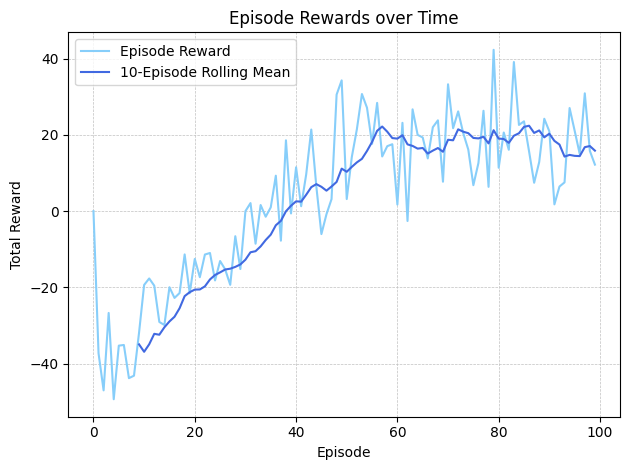

In [19]:
plt.plot(lin_stats["episode_rewards"], color="lightskyblue", label="Episode Reward")
plt.plot(pd.Series(lin_stats["episode_rewards"]).rolling(10).mean(), color="royalblue", label="10-Episode Rolling Mean")
plt.title("Episode Rewards over Time")
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.grid(color="silver", linestyle='--', linewidth=0.5)

plt.legend()
plt.tight_layout()
plt.show()

3. Use a neural network to approximate $q_\pi(a, s)$ and solve the control problem using Q-learning.
You may want to consider the use of feature engineering to pre-process the state.

In [20]:
class QNetwork(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(QNetwork, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, output_dim)
        )

    def forward(self, x):
        return self.network(x)


input_dim = feature_transformer.transform([get_state(*env.reset())]).shape[1]
output_dim = env.action_space.n

q_network = QNetwork(input_dim, output_dim)
optimizer = optim.Adam(q_network.parameters(), lr=1e-5)


def NN_q_learning(env, network, num_episodes=100, num_steps=1000, discount_factor=1.0, epsilon_start=1.0,
                  epsilon_decay=0.99, epsilon_min=0.1):
    stats = {"episode_rewards": np.zeros(num_episodes)}
    network.train()

    for episode in range(1, num_episodes):
        obs, info = env.reset()
        state = get_state(obs, info)
        state = feature_transformer.transform([state])
        epsilon = max(epsilon_min, epsilon_start * (epsilon_decay ** episode))

        for step in range(1, num_steps):
            if random.random() < epsilon:
                action = env.action_space.sample()
            else:
                q_values = network(torch.FloatTensor(state))
                action = q_values.argmax().item()

            next_obs, reward, _, _, next_info = env.step(action)
            next_state = feature_transformer.transform([get_state(next_obs, next_info)])

            stats["episode_rewards"][episode] += reward

            q_values_next = network(torch.FloatTensor(next_state))
            max_q_value_next = q_values_next.max().item()
            td_target = reward + discount_factor * max_q_value_next

            q_value = network(torch.FloatTensor(state))[:, action]
            loss = torch.square(q_value - torch.tensor(td_target))

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            state = next_state

            print("\rEpisode: {}/{}   Step: {}/{}    {}".format(episode, num_episodes, step, num_steps,
                                                                round(epsilon, 3)), end="")
    return stats

In [21]:
NN_stats = NN_q_learning(env, q_network)

Episode: 99/100   Step: 999/1000    0.373

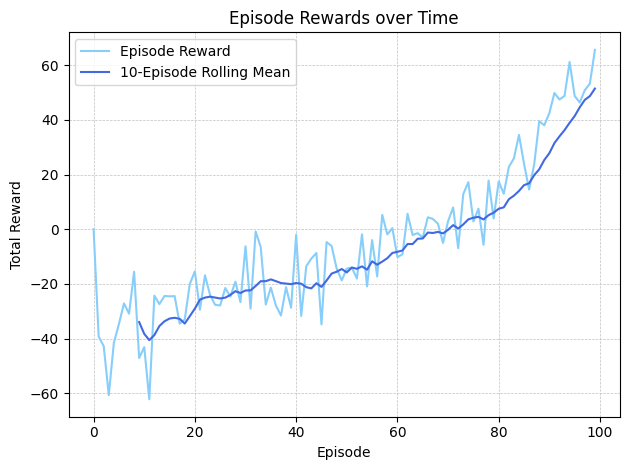

In [22]:
plt.plot(NN_stats["episode_rewards"], color="lightskyblue", label="Episode Reward")
plt.plot(pd.Series(NN_stats["episode_rewards"]).rolling(10).mean(), color="royalblue", label="10-Episode Rolling Mean")
plt.title("Episode Rewards over Time")
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.grid(color="silver", linestyle='--', linewidth=0.5)

plt.legend()
plt.tight_layout()
plt.show()